# RAG Retrieval Enhanced with Document Summaries
In this section, we'll implement an improved approach to our retrieval system by incorporating document summaries. Instead of embedding chunks directly from the documents, we'll create a concise summary for each chunk and use this summary along with the original content in our embedding process.

This approach aims to capture the essence of each document chunk more effectively, potentially leading to improved retrieval performance.

Key steps in this process:

1. We load the original document chunks.
2. For each chunk, we generate a 2-3 sentence summary using OpenAI (or an OpenAI compatible API).
3. We store both the original content and the summary for each chunk in a new json file: data/anthropic_summary_indexed_docs.json

This summary-enhanced approach is designed to provide more context during the embedding and retrieval phases, potentially improving the system's ability to understand and match the most relevant documents to user queries.

In [9]:
## silent setup (-q), may take a while
!pip install openai -q
!pip install --upgrade tiktoken -q
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install -U scikit-learn -q
!pip install sentence-transformers -q
!pip install pyyaml -q

In [10]:
# model configuration
embeddings_model = "intfloat/multilingual-e5-large-instruct"; generation_model = "gpt-4o-mini"; judge_model = "gpt-4o-mini"

In [11]:
import os
import getpass
from openai import OpenAI
OPENAI_API_KEY = getpass.getpass("Enter OpenAI API key")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
# print(os.environ.get("OPENAI_API_KEY"))
client = OpenAI()

Enter OpenAI API key ········


In [12]:
from sentence_transformers import SentenceTransformer
embeddings_model = SentenceTransformer(embeddings_model)

/opt/vast-jupyter/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

### Generating the Summaries and Storing Them
You can invoke this depending on whether its already available

In [13]:
# TODO, this is for Claud-3-haiku, need to be changed to OpenAI or Llama
import json
from tqdm import tqdm

def generate_summaries(input_file, output_file):
 
    # Load the original documents
    with open(input_file, 'r') as f:
        docs = json.load(f)

    # Prepare the context about the overall knowledge base
    knowledge_base_context = "This is documentation for Anthropic's, a frontier AI lab building Claude, an LLM that excels at a variety of general purpose tasks. These docs contain model details and documentation on Anthropic's APIs."

    summarized_docs = []

    for doc in tqdm(docs, desc="Generating summaries"):
        prompt = f"""
        You are tasked with creating a short summary of the following content from Anthropic's documentation. 

        Context about the knowledge base:
        {knowledge_base_context}

        Content to summarize:
        Heading: {doc['chunk_heading']}
        {doc['text']}

        Please provide a brief summary of the above content in 2-3 sentences. The summary should capture the key points and be concise. We will be using it as a key part of our search pipeline when answering user queries about this content. 

        Avoid using any preamble whatsoever in your response. Statements such as 'here is the summary' or 'the summary is as follows' are prohibited. You should get straight into the summary itself and be concise. Every word matters.
        """

        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=150,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        summary = response.content[0].text.strip()

        summarized_doc = {
            "chunk_link": doc["chunk_link"],
            "chunk_heading": doc["chunk_heading"],
            "text": doc["text"],
            "summary": summary
        }
        summarized_docs.append(summarized_doc)

    # Save the summarized documents to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(summarized_docs, f, indent=2)

    print(f"Summaries generated and saved to {output_file}")
    
# this is already available, so the call is commented out
# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

### Summary-Enhanced Vector Database Creation (heading + summary + chunk)
Here, we're creating a new vector database that incorporates our summary-enhanced document chunks. This approach combines the original text, the chunk heading, and the newly generated summary into a single text for embedding.

Key features of this process:

1. We create embeddings for the combined text (heading + summary + original content) using the Voyage AI API.
2. The embeddings and full metadata (including summaries) are stored in our vector database.
3. We implement caching mechanisms to improve efficiency in repeated queries.
4. The database is saved to disk for persistence and quick loading in future sessions.

This summary-enhanced approach aims to create more informative embeddings, potentially leading to more accurate and contextually relevant document retrieval.

In [14]:
import os
import numpy as np
import pickle
import json

class SummaryEnhancedVectorDB:
    def __init__(self, name, api_key=None):
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"

    def _embed_and_store(self, texts, data):
        """not called for now"""
        batch_size = 128
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data
        
    def load_data(self, data_file):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print(f"Loading vector database from file: {self.db_path}.")
            self.load_db()
            return
            
        # well, if not...
        print(f'file {self.db_path} does not exist')
        with open(data_file, 'r') as f:
            data = json.load(f)
            
        # Embed Chunk Heading + Text + Summary Together
        texts = [f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}" for item in data]  
        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data  # Store the entire item as metadata
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=3, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            # print(f'found in cache!')
            query_embedding = np.array(self.query_cache[query])  #
            # print(f'type:{type(query_embedding)}')
        else:
            query_embedding = embeddings_model.encode(query, normalize_embeddings=True)
            # print(f'query embedding:\n {query_embedding}')
            self.query_cache[query] = query_embedding.tolist()

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        # self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        print(f'Saving DB in: {self.db_path}')
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

In [15]:
#previewing our eval dataset
import json

def preview_json(file_path, num_items=3):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            
        if isinstance(data, list):
            preview_data = data[:num_items]
        elif isinstance(data, dict):
            preview_data = dict(list(data.items())[:num_items])
        else:
            print(f"Unexpected data type: {type(data)}. Cannot preview.")
            return
        
        print(f"Preview of the first {num_items} items from {file_path}:")
        print(json.dumps(preview_data, indent=2))
        print(f"\nTotal number of items: {len(data)}")
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Invalid JSON in file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

preview_json('evaluation/docs_evaluation_dataset.json')


Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

### Enhanced Retrieval Using Summary-Enhanced Embeddings
In this section, we implement the retrieval process using our new summary-enhanced vector database. This approach leverages the enhanced embeddings we created, which incorporate document summaries along with the original content.

Key aspects of this updated retrieval process:

1. We search the vector database using the query embedding, retrieving the top k most similar documents.
2. For each retrieved document, we include the chunk heading, summary, and full text in the context provided to the LLM.
3. This enriched context is then used to generate an answer to the user's query.

By including summaries in both the embedding and retrieval phases, we aim to provide the LLM with a more comprehensive and focused context. This could potentially lead to more accurate and relevant answers, as the LLM has access to both a concise overview (the summary) and the detailed information (the full text) for each relevant document chunk.

In [16]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
from typing import Callable, List, Dict, Any, Tuple, Set

def retrieve_similar_level_two(query, db):
    # print(f'_______Query used for retrieval________:\n {query}')
    results = db.search(query, k=3)
    context = ""
    for i, result in enumerate(results):
        chunk = result['metadata']
        # show model all 3 items; heading, text, summary
        context += f"\n <document> \n Heading:\n{chunk['chunk_heading']}\n\nText:\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" 
    
        # print(f'-----------start retrieval {i} --------------')
        # print(f"__Retrieved results heading__:\n{result['metadata']['chunk_heading']}")
        # print(f"__Retrieved results text__:\n{result['metadata']['text']}")
        # print(f"__Retrieved results summary__:\n{result['metadata']['summary']}")
        # print(f'-----------end retrieval {i} ----------------')
        
    return results, context

def construct_prompt(query, context):    
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """

    return prompt

def answer_query_from_context_level_two(query, db):
    documents, context = retrieve_similar_level_two(query, db)
    # print(f'query + context:\n{construct_prompt(query, context)}')
    completion = client.chat.completions.create(
    model=generation_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": construct_prompt(query, context)
            }
        ],
        temperature=0.2
    )
    return completion.choices[0].message.content

# Load the evaluation dataset
with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Initialize the SummaryEnhancedVectorDB
level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
level_two_db.load_data('data/anthropic_summary_indexed_docs.json')
level_two_db.save_db()

# # Load the Anthropic documentation
# with open('data/anthropic_docs.json', 'r') as f:
#     anthropic_docs = json.load(f)

# test
#query = "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?"
query = "What are two ways that Claude for Sheets can improve prompt engineering workflows compared to using chained prompts?"
test_results, test_contexts = retrieve_similar_level_two(query, level_two_db)
# for i, test_result in enumerate(test_results):
#     print(f'ith:{i}\n {test_result}')

file ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl does not exist
Saving DB in: ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl
Vector database loaded and saved.
Saving DB in: ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl


### Defining Our Metric Calculation Functions

In [17]:
def calculate_mrr(retrieved_links: List[str], correct_links: Set[str]) -> float:
    for i, link in enumerate(retrieved_links, 1):
        if link in correct_links:
            return 1 / i
    return 0

def evaluate_retrieval(retrieval_function: Callable, evaluation_data: List[Dict[str, Any]], db: Any) -> Tuple[float, float, float, float, List[float], List[float], List[float]]:
    precisions = []
    recalls = []
    mrrs = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Evaluating Retrieval")):
        try:
            retrieved_chunks, _ = retrieval_function(item['question'], db)
            retrieved_links = [chunk['metadata'].get('chunk_link', chunk['metadata'].get('url', '')) for chunk in retrieved_chunks]
        except Exception as e:
            logging.error(f"Error in retrieval function: {e}")
            continue

        correct_links = set(item['correct_chunks'])
        
        true_positives = len(set(retrieved_links) & correct_links)
        precision = true_positives / len(retrieved_links) if retrieved_links else 0
        recall = true_positives / len(correct_links) if correct_links else 0
        mrr = calculate_mrr(retrieved_links, correct_links)
        
        precisions.append(precision)
        recalls.append(recall)
        mrrs.append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(evaluation_data)} items. Current Avg Precision: {sum(precisions) / len(precisions):.4f}, Avg Recall: {sum(recalls) / len(recalls):.4f}, Avg MRR: {sum(mrrs) / len(mrrs):.4f}")
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs

import tiktoken
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """For OpenAI models, returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def evaluate_end_to_end(answer_query_function, db, eval_data):
    correct_answers = 0
    results = []
    total_questions = len(eval_data)
    
    for i, item in enumerate(tqdm(eval_data, desc="Evaluating End-to-End")):
        query = item['question']
        correct_answer = item['correct_answer']
        generated_answer = answer_query_function(query, db) # ??
        
        comparision_prompt = f"""
        You are an AI assistant tasked with evaluating the correctness of answers to questions about Anthropic's documentation.
        
        Question: {query}
        
        Correct Answer: {correct_answer}
        
        Generated Answer: {generated_answer}
        
        Is the Generated Answer correct based on the Correct Answer? You should pay attention to the substance of the answer, and ignore minute details that may differ. 
        
        Small differences or changes in wording don't matter. If the generated answer and correct answer are saying essentially the same thing then that generated answer should be marked correct. 
        
        However, if there is any critical piece of information which is missing from the generated answer in comparison to the correct answer, then we should mark this as incorrect. 
        
        Finally, if there are any direct contradictions between the correct answer and generated answer, we should deem the generated answer to be incorrect.
        
        Respond in the following XML format (don't prefix with xml):
        <evaluation>
        <content>
        <explanation>Your explanation here</explanation>
        <is_correct>true/false</is_correct>
        </content>
        </evaluation>
        """
        
        nb_tokens = num_tokens_from_string(comparision_prompt, "o200k_base")  # note, this encoding name is for gpt-4o, gpt-4o-mini
        
        try:
            response = client.chat.completions.create(
                model=judge_model,
                messages=[
                    {"role": "system", "content": "You are a helpful judge."},
                    {"role": "user", "content": comparision_prompt}
                ],
                temperature=0.2,
            )
            response_text = str(response.choices[0].message.content)
            print(f'Number of query tokens: {nb_tokens}, Query:\n{query}')
            print(f'__Correct answer__:\n{correct_answer}')
            print(f'__Generated answer__:\n{generated_answer}')
            print(f'__Response from judge LLM__:\n{response_text}')
            
            evaluation = ET.fromstring(response_text)
            is_correct_value = evaluation.find(".//is_correct").text
            
            is_correct = is_correct_value == 'true'
            
            if is_correct:
                correct_answers += 1
            results.append(is_correct)
            
            logging.info(f"Question {i + 1}/{total_questions}: {query}")
            logging.info(f"Correct: {is_correct}")
            logging.info("---")
            
        except ET.ParseError as e:
            logging.error(f"XML parsing error: {e}")
            is_correct = 'true' in response_text.lower()
            results.append(is_correct)
        except Exception as e:
            logging.error(f"Unexpected error: {e}")
            results.append(False)
        
        if (i + 1) % 10 == 0:
            current_accuracy = correct_answers / (i + 1)
            print(f"Processed {i + 1}/{total_questions} questions. Current Accuracy: {current_accuracy:.4f}")
        # time.sleep(2)
    accuracy = correct_answers / total_questions
    return accuracy, results



In [18]:
# Initialize the SummaryIndexedVectorDB
# level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
# level_two_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
eval_data_range = eval_data[0:100]
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_similar_level_two, eval_data_range, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_from_context_level_two, level_two_db, eval_data_range)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data_range],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
from pathlib import Path
csv_dir = Path('evaluation/csvs')
csv_file_name = Path('evaluation_results_summary_enhanced.csv')
df.to_csv(csv_dir / csv_file_name, index=False)
print(f"Detailed results saved to {csv_dir/ csv_file_name}")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a json file
json_dir = Path("evaluation/json_results")
result_file_name = Path("evaluation_results_summary_enhanced.json")
Path(json_dir).mkdir(parents=True, exist_ok=True)
with open(json_dir / result_file_name, 'w') as f:
    json.dump({
        "name": "Summary Enhanced",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print(f"Evaluation complete. Results saved to {json_dir / result_file_name}, {csv_dir/ csv_file_name}")

Evaluating Retrieval:  15%|█▌        | 15/100 [00:00<00:02, 32.63it/s]

Processed 10/100 items. Current Avg Precision: 0.4667, Avg Recall: 0.7500, Avg MRR: 0.8000


Evaluating Retrieval:  27%|██▋       | 27/100 [00:00<00:02, 36.25it/s]

Processed 20/100 items. Current Avg Precision: 0.3833, Avg Recall: 0.6250, Avg MRR: 0.6667


Evaluating Retrieval:  35%|███▌      | 35/100 [00:01<00:01, 37.20it/s]

Processed 30/100 items. Current Avg Precision: 0.3889, Avg Recall: 0.6222, Avg MRR: 0.7278


Evaluating Retrieval:  47%|████▋     | 47/100 [00:01<00:01, 37.97it/s]

Processed 40/100 items. Current Avg Precision: 0.4250, Avg Recall: 0.6542, Avg MRR: 0.7458


Evaluating Retrieval:  55%|█████▌    | 55/100 [00:01<00:01, 38.07it/s]

Processed 50/100 items. Current Avg Precision: 0.4267, Avg Recall: 0.6733, Avg MRR: 0.7467


Evaluating Retrieval:  67%|██████▋   | 67/100 [00:01<00:00, 38.16it/s]

Processed 60/100 items. Current Avg Precision: 0.4222, Avg Recall: 0.6806, Avg MRR: 0.7722


Evaluating Retrieval:  75%|███████▌  | 75/100 [00:02<00:00, 38.08it/s]

Processed 70/100 items. Current Avg Precision: 0.4095, Avg Recall: 0.6512, Avg MRR: 0.7452


Evaluating Retrieval:  87%|████████▋ | 87/100 [00:02<00:00, 38.06it/s]

Processed 80/100 items. Current Avg Precision: 0.4167, Avg Recall: 0.6635, Avg MRR: 0.7583


Evaluating Retrieval:  95%|█████████▌| 95/100 [00:02<00:00, 37.90it/s]

Processed 90/100 items. Current Avg Precision: 0.4111, Avg Recall: 0.6546, Avg MRR: 0.7500


Evaluating Retrieval: 100%|██████████| 100/100 [00:02<00:00, 36.85it/s]


Processed 100/100 items. Current Avg Precision: 0.3967, Avg Recall: 0.6325, Avg MRR: 0.7300


Evaluating End-to-End:   1%|          | 1/100 [00:08<13:23,  8.11s/it]

Number of query tokens: 506, Query:
How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?
__Correct answer__:
To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios.
__Generated answer__:
To create multiple test cases for evaluation in the Anthropic Evaluation tool, follow these steps:

1. **Access the Evaluation Screen**: Open the Anthropic Console and navigate to the prompt editor. After composing your prompt, look for the ‘Evaluate’ tab at the top of the screen.

2. **Ensure Dynamic Variables**: Make sure your prompt includes at least 1-2 dynamic variables using the double brace syntax (e.g., {{variable}}). This is necessary for creating evaluation test sets.

3. **Add Test Cases**: On the Evaluation screen, you will see a single row for your test case. To add more test cases, click the ‘Add T

Evaluating End-to-End:   2%|▏         | 2/100 [00:10<07:51,  4.82s/it]

Number of query tokens: 336, Query:
What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?
__Correct answer__:
Anthropic recommends Voyage AI for embedding models. Voyage AI offers customized models for specific industry domains like finance and healthcare, as well as bespoke fine-tuned models for individual customers. They have a wide variety of options and capabilities.
__Generated answer__:
Anthropic recommends Voyage AI as the embeddings provider for customized domain-specific models. Voyage AI offers state-of-the-art embedding models and provides options for customized models tailored to specific industry domains, such as finance and healthcare, as well as bespoke fine-tuned models for individual customers.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer. It mentions that Anthropic recommends Voya

Evaluating End-to-End:   3%|▎         | 3/100 [00:16<08:47,  5.44s/it]

Number of query tokens: 627, Query:
What are some key success metrics to consider when evaluating Claude's performance on a classification task, and how do they relate to choosing the right model to reduce latency?
__Correct answer__:
When evaluating Claude's performance on a classification task, some key success metrics to consider include accuracy, F1 score, consistency, structure, speed, bias and fairness. Choosing the right model that fits your specific requirements in terms of speed and output quality is a straightforward way to reduce latency and meet the acceptable response time for your use case.
__Generated answer__:
Key success metrics to consider when evaluating Claude's performance on a classification task include:

1. **Accuracy**: Measures the proportion of correct predictions made by the model. It is calculated as the number of correct predictions divided by the total number of predictions.

2. **F1 Score**: This metric balances precision and recall, providing a single s

Evaluating End-to-End:   4%|▍         | 4/100 [00:20<07:54,  4.94s/it]

Number of query tokens: 426, Query:
What are two ways that Claude for Sheets can improve prompt engineering workflows compared to using chained prompts?
__Correct answer__:
Claude for Sheets enables testing prompts across evaluation suites in parallel, which is faster than running chained prompts sequentially. It also excels at office tasks like survey analysis and online data processing that may be more cumbersome with chained prompts.
__Generated answer__:
Claude for Sheets can improve prompt engineering workflows compared to using chained prompts in two significant ways:

1. **Parallel Testing of Prompts**: Claude for Sheets allows users to test multiple prompts across evaluation suites simultaneously. This capability enables more efficient experimentation and iteration, as users can quickly assess the effectiveness of various prompts without the need to execute them sequentially, which is often the case with chained prompts.

2. **Centralized Resource for Examples and Structures**:

Evaluating End-to-End:   5%|▌         | 5/100 [00:24<06:45,  4.27s/it]

Number of query tokens: 348, Query:
What happens if a prompt for the Text Completions API is missing the "\n\nHuman:" and "\n\nAssistant:" turns?
__Correct answer__:
If a prompt for the Text Completions API is missing the required "\n\nHuman:" and "\n\nAssistant:" turns, it will result in an API error.
__Generated answer__:
If a prompt for the Text Completions API is missing the "\n\nHuman:" and "\n\nAssistant:" turns, it will result in an API error. The API requires these specific markers to properly identify the roles of the participants in the conversation. Without them, the prompt is considered invalid, and the API will not process it.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer. Both state that the absence of the required "\n\nHuman:" and "\n\nAssistant:" turns will result in an API error, and the generated answer adds that these markers are necessary for identifying the ro

Evaluating End-to-End:   6%|▌         | 6/100 [00:31<08:07,  5.19s/it]

Number of query tokens: 484, Query:
How do the additional tokens required for tool use in Claude API requests impact pricing compared to regular API requests?
__Correct answer__:
Tool use requests in the Claude API are priced the same as regular API requests, based on the total input and output tokens. However, tool use requests have additional tokens beyond the regular input and output, including the tools parameter, tool use content blocks, tool result content blocks, and a special system prompt that enables tool use, which add to the total tokens and cost.
__Generated answer__:
The additional tokens required for tool use in Claude API requests impact pricing by increasing the total number of input and output tokens counted for each request. Tool use requests are priced the same as regular API requests, based on the total number of tokens, which includes:

1. Tokens from the tools parameter (tool names, descriptions, and schemas).
2. Tokens from tool_use content blocks in API request

Evaluating End-to-End:   7%|▋         | 7/100 [00:33<06:30,  4.20s/it]

Number of query tokens: 311, Query:
When will the new Anthropic Developer Console features that show API usage, billing details, and rate limits be available?
__Correct answer__:
The new Usage, Cost, and Rate Limits tabs in the Anthropic Developer Console that show API usage, billing details, and current rate limits will be available on June 27th, 2024.
__Generated answer__:
The new Anthropic Developer Console features that show API usage, billing details, and rate limits will be available on June 27th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer states that the new features will be available on June 27th, 2024, which matches the information provided in the correct answer. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:   8%|▊         | 8/100 [00:36<06:11,  4.04s/it]

Number of query tokens: 417, Query:
When deciding whether to use chain-of-thought (CoT) for a task, what are two key factors to consider in order to strike the right balance between performance and latency?
__Correct answer__:
When deciding whether to use CoT, consider if the task requires in-depth thinking that a human would need to work through, and be aware that the increased output length from CoT may impact latency.
__Generated answer__:
When deciding whether to use chain-of-thought (CoT) for a task, two key factors to consider are:

1. **Task Complexity**: CoT should be used for tasks that require in-depth thinking, such as complex math, multi-step analysis, or writing complex documents. If the task does not necessitate extensive processing, it may be better to avoid CoT to reduce latency.

2. **Model Selection**: Choosing the right model is crucial for optimizing both performance and latency. Different models have varying capabilities and performance characteristics, so selectin

Evaluating End-to-End:   9%|▉         | 9/100 [00:42<07:00,  4.62s/it]

Number of query tokens: 586, Query:
How can I use Claude to more easily digest the content of long PDF documents?
__Correct answer__:
You can upload PDFs and have Claude summarize their content, making it easier to understand the key points of long documents without having to read through everything.
__Generated answer__:
To use Claude for digesting long PDF documents more easily, follow these strategies:

1. **Place Longform Data at the Top**: Start your prompt with the content of the PDF document. This should be the first thing Claude sees, as it helps improve performance, especially for long documents (around 20K+ tokens). 

2. **Structure Content with XML Tags**: If you're working with multiple documents or sections, wrap each document in `<document>` tags and include `<document_content>` and `<source>` tags for clarity. This structured approach helps Claude understand the context better.

   Example structure:
   ```xml
   <documents>
     <document index="1">
       <source>your_

Evaluating End-to-End:  10%|█         | 10/100 [00:44<05:39,  3.77s/it]

Number of query tokens: 276, Query:
According to the documentation, where can you view your organization's current API rate limits in the Anthropic Console?
__Correct answer__:
You can view your organization's current API rate limits in the Rate Limits tab of the Developer Console.
__Generated answer__:
You can view your organization's current API rate limits in the new Rate Limits tab in the Developer Console.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer conveys the same essential information as the correct answer, stating that the API rate limits can be viewed in the Rate Limits tab of the Developer Console. The addition of "new" does not change the substance of the answer. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 10/100 questions. Current Accuracy: 0.9000


Evaluating End-to-End:  11%|█         | 11/100 [00:49<06:07,  4.13s/it]

Number of query tokens: 494, Query:
How can we measure the performance of the ticket classification system implemented using Claude beyond just accuracy?
__Correct answer__:
In addition to accuracy, we can measure the 95th percentile response time and average cost per classification to assess the ticket classification system's performance and production-readiness.
__Generated answer__:
To measure the performance of the ticket classification system implemented using Claude beyond just accuracy, consider the following evaluation metrics:

1. **F1 Score**: This metric balances precision and recall, providing a better measure of a model's performance when dealing with imbalanced classes.

2. **Consistency**: Evaluate whether the model's outputs are consistent for similar inputs, ensuring it follows a logical pattern in its predictions.

3. **Structure**: Assess if the model's output adheres to the expected format, such as JSON, which makes it easier to parse and interpret.

4. **Speed**: M

Evaluating End-to-End:  12%|█▏        | 12/100 [00:54<06:20,  4.32s/it]

Number of query tokens: 486, Query:
How can you specify a system prompt using the Text Completions API versus the Messages API?
__Correct answer__:
With the Text Completions API, the system prompt is added as text before the first "\n\nHuman:" turn. With the Messages API, the system prompt is specified using the separate "system" parameter when making the API request.
__Generated answer__:
To specify a system prompt using the Text Completions API, you add the text before the first `\n\nHuman:` turn in your prompt. For example:

```python
prompt = "Today is January 1, 2024.\n\nHuman: Hello, Claude\n\nAssistant:"
```

In contrast, when using the Messages API, you specify the system prompt with the `system` parameter in the API call. For example:

```python
anthropic.Anthropic().messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1024,
    system="Today is January 1, 2024.",  # <-- system prompt
    messages=[
        {"role": "user", "content": "Hello, Claude"}
    ]
)
``

ERROR:root:XML parsing error: mismatched tag: line 3, column 699
Evaluating End-to-End:  13%|█▎        | 13/100 [01:01<07:28,  5.15s/it]

Number of query tokens: 635, Query:
How can you combine XML tags with chain of thought reasoning to create high-performance prompts for Claude?
__Correct answer__:
You can combine XML tags like <thinking> and <answer> with chain of thought reasoning, where Claude explains its step-by-step reasoning process, to create structured, high-performance prompts. For example, you can prompt Claude to show its reasoning by including "Before answering, explain your reasoning step-by-step in <thinking> tags." in the user message or system prompt.
__Generated answer__:
To combine XML tags with chain of thought reasoning for creating high-performance prompts for Claude, follow these steps:

1. **Identify Subtasks**: Break down your main task into distinct, sequential subtasks. Each subtask should have a single, clear objective.

2. **Use XML Tags for Structure**: Implement XML tags to clearly separate different parts of your prompt. This enhances clarity and reduces the likelihood of misinterpretati

Evaluating End-to-End:  14%|█▍        | 14/100 [01:05<06:56,  4.85s/it]

Number of query tokens: 446, Query:
When evaluating the Claude model's performance for ticket routing, what three key metrics are calculated and what are the results for the claude-3-haiku-20240307 model on the 91 test samples?
__Correct answer__:
When evaluating the claude-3-haiku-20240307 model's performance on the 91 test samples, the three key metrics calculated are accuracy (89.01%), 95th percentile response time (1.61 seconds), and average cost per request routing ($0.0004).
__Generated answer__:
The three key metrics calculated when evaluating the Claude model's performance for ticket routing are:

1. **Accuracy**: This measures how often the model's predictions match the correct classifications.
2. **F1 Score**: This metric balances precision and recall, providing a single score that reflects the model's performance on both false positives and false negatives.
3. **Consistency**: This assesses whether the model's outputs are logical and consistent for similar inputs.

The resul

Evaluating End-to-End:  15%|█▌        | 15/100 [01:08<05:54,  4.17s/it]

Number of query tokens: 364, Query:
Before starting to engineer and improve a prompt in Claude, what key things does Anthropic recommend you have in place first?
__Correct answer__:
Before prompt engineering, Anthropic highly recommends having a clear definition of success criteria for your use case, some ways to empirically test against those criteria, and a first draft prompt you want to improve.
__Generated answer__:
Before starting to engineer and improve a prompt in Claude, Anthropic recommends having the following key things in place:

1. A clear definition of the success criteria for your use case.
2. Some ways to empirically test against those criteria.
3. A first draft prompt that you want to improve.

If you do not have a first draft prompt, Anthropic suggests using the prompt generator available in the Anthropic Console.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the key recommendations from Anthropic regarding p

Evaluating End-to-End:  16%|█▌        | 16/100 [01:12<05:54,  4.22s/it]

Number of query tokens: 465, Query:
How does the Messages API handle mid-response prompting compared to the Text Completions API?
__Correct answer__:
The Messages API allows you to continue a response by making the last input message have the "assistant" role, whereas the Text Completions API lets you pre-fill part of Claude's response directly in the prompt string.
__Generated answer__:
The Messages API handles mid-response prompting by allowing the last input message to have the assistant role, which enables the response to continue from that point. This means you can pre-fill part of the assistant's response directly in the message structure. For example, you can specify an assistant message with a partial response, and the model will continue from there.

In contrast, the Text Completions API allows you to pre-fill part of the response by setting the prompt to start with the assistant's response. This is done using raw string prompts that alternate between "Human:" and "Assistant:"

Evaluating End-to-End:  17%|█▋        | 17/100 [01:17<06:11,  4.48s/it]

Number of query tokens: 538, Query:
How does Claude's response differ when given a role through a system prompt compared to not having a specific role in the financial analysis example?
__Correct answer__:
When given the role of CFO through a system prompt, Claude provides a much more insightful, structured, and actionable financial analysis compared to not having a specific role. The role-based response breaks down key financial metrics, provides strategic commentary, and makes specific recommendations.
__Generated answer__:
Claude's response differs significantly when given a specific role through a system prompt compared to not having a defined role in a financial analysis context. 

When a role is assigned, such as "You are a seasoned data scientist at a Fortune 500 company," Claude's performance is enhanced in several ways:

1. **Enhanced Accuracy**: The role prompting improves Claude's ability to handle complex scenarios, leading to more precise and relevant analyses.

2. **Tailo

Evaluating End-to-End:  18%|█▊        | 18/100 [01:25<07:20,  5.37s/it]

Number of query tokens: 721, Query:
What are some quantitative metrics that can be used to measure the success of a sentiment analysis model, and how might specific targets for those metrics be determined?
__Correct answer__:
Quantitative metrics for evaluating a sentiment analysis model include task-specific metrics like F1 score, as well as generic metrics like accuracy, precision, and recall. Specific targets should be based on industry benchmarks, prior experiments, AI research, or expert knowledge, and should represent an improvement over the current baseline.
__Generated answer__:
Quantitative metrics that can be used to measure the success of a sentiment analysis model include:

1. **Accuracy**: The proportion of correct predictions made by the model, calculated as (Number of correct predictions) / (Total number of predictions).

2. **F1 Score**: A measure that balances precision and recall, providing a single score that reflects both the model's ability to correctly identify po

Evaluating End-to-End:  19%|█▉        | 19/100 [01:29<06:42,  4.97s/it]

Number of query tokens: 314, Query:
What is a power user tip mentioned in the documentation for creating high-performance prompts using XML tags?
__Correct answer__:
Combining XML tags with other prompt engineering techniques like multishot prompting (using <examples> tags) or chain of thought (using <thinking> and <answer> tags) to create super-structured, high-performance prompts.
__Generated answer__:
Combine XML tags with other techniques like multishot prompting (<examples>) or chain of thought (<thinking>, <answer>). This creates super-structured, high-performance prompts.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately captures the essence of the correct answer by mentioning the combination of XML tags with multishot prompting and chain of thought techniques. It conveys the same idea of creating super-structured, high-performance prompts without omitting any critical information. Therefore, the generated answer is correct.</explan

Evaluating End-to-End:  20%|██        | 20/100 [01:38<08:25,  6.32s/it]

Number of query tokens: 894, Query:
How can you use an LLM like Claude to automatically grade the outputs of other LLMs based on a rubric?
__Correct answer__:
You can use an LLM like Claude to grade the outputs of other LLMs by providing it with the output to grade along with a detailed rubric. Instruct the LLM to think through its reasoning and then output a simple 'correct' or 'incorrect' result based on how well the output matches the criteria in the rubric.
__Generated answer__:
To use an LLM like Claude to automatically grade the outputs of other LLMs based on a rubric, follow these steps:

1. **Develop a Clear Rubric**: Create a detailed and clear rubric that outlines the criteria for grading. For example, specify that certain key phrases must be included in the response, or define a scoring scale (e.g., 1-5) for qualitative assessments.

2. **Construct Grading Prompts**: Use a function to build a prompt for Claude that includes the answer to be graded and the rubric. The prompt 

Evaluating End-to-End:  21%|██        | 21/100 [01:42<07:25,  5.64s/it]

Number of query tokens: 563, Query:
How can you access and deploy Voyage embeddings on AWS Marketplace?
__Correct answer__:
To access Voyage embeddings on AWS, subscribe to the model package on AWS Marketplace, select the model to deploy, agree to the terms, and copy the Product ARN for your selected region. Then create a JupyterLab space in SageMaker Studio, upload Voyage's notebook, and follow the instructions to deploy the model package using the ARN.
__Generated answer__:
To access and deploy Voyage embeddings on AWS Marketplace, follow these steps:

1. **Subscribe to the Model Package**:
   - Navigate to the model package listing page on AWS Marketplace and select the Voyage model you wish to deploy.
   - Click on the "Continue to subscribe" button.
   - Review the details on the "Subscribe to this software" page. If you agree with the End-User License Agreement (EULA), pricing, and support terms, click on "Accept Offer".
   - After selecting "Continue to configuration" and choosi

Evaluating End-to-End:  22%|██▏       | 22/100 [01:48<07:21,  5.66s/it]

Number of query tokens: 619, Query:
When using tools just to get Claude to produce JSON output following a particular schema, what key things should you do in terms of tool setup and prompting?
__Correct answer__:
When using tools to get JSON output, you should provide a single tool, set the tool_choice to explicitly instruct the model to use that tool, and ensure the tool name and description are from the model's perspective since it will pass the input to the tool.
__Generated answer__:
To effectively set up tools for Claude to produce JSON output following a specific schema, you should focus on the following key aspects:

1. **Define Tools Clearly**: When integrating tools, ensure that you provide clear definitions for each tool, including names, descriptions, and input schemas. This helps Claude understand how to use the tools effectively.

2. **Craft an Appropriate User Prompt**: Include a user prompt that is relevant to the tools you have defined. The prompt should indicate the n

Evaluating End-to-End:  23%|██▎       | 23/100 [01:54<07:36,  5.93s/it]

Number of query tokens: 605, Query:
What are the key differences between the legacy Claude Instant 1.2 model and the Claude 3 Haiku model in terms of capabilities and performance?
__Correct answer__:
The Claude 3 Haiku model has vision capabilities, is faster, more performant, and more intelligent than the legacy Claude Instant 1.2 model. Claude 3 Haiku also has more up-to-date training data.
__Generated answer__:
The key differences between the legacy Claude Instant 1.2 model and the Claude 3 Haiku model in terms of capabilities and performance are as follows:

1. **Performance**: Claude Instant 1.2 is described as a fast and efficient model but is considered less performant compared to the Claude 3 models. The Claude 3 family, including Claude 3 Haiku, offers improved capabilities and overall intelligence.

2. **Multilingual Capabilities**: While Claude Instant 1.2 has some multilingual capabilities, it has less coverage, understanding, and skill compared to the Claude 3 models. The 

Evaluating End-to-End:  24%|██▍       | 24/100 [01:56<06:01,  4.75s/it]

Number of query tokens: 277, Query:
What is one key benefit of using examples when prompt engineering with Claude?
__Correct answer__:
One key benefit of using examples in prompts is that they reduce misinterpretation of instructions, leading to more accurate outputs from Claude.
__Generated answer__:
One key benefit of using examples when prompt engineering with Claude is that examples reduce misinterpretation of instructions.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer captures the essence of the correct answer by stating that examples reduce misinterpretation of instructions. However, it omits the part about leading to more accurate outputs from Claude, which is a critical piece of information. Therefore, the generated answer is not fully correct.</explanation>
<is_correct>false</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  25%|██▌       | 25/100 [01:59<05:13,  4.18s/it]

Number of query tokens: 368, Query:
According to the Anthropic documentation, what is one key advantage of using prompt engineering instead of fine-tuning when it comes to adapting an AI model to new domains or tasks?
__Correct answer__:
Prompt engineering allows you to easily adapt AI models to new domains by providing domain-specific context directly in the prompts, without needing to retrain the model through fine-tuning.
__Generated answer__:
One key advantage of using prompt engineering instead of fine-tuning when adapting an AI model to new domains or tasks is that prompt engineering is far faster and more resource-efficient. It allows for nearly instantaneous results and requires only text input, while fine-tuning necessitates high-end GPUs, large memory, and substantial task-specific labeled data, making prompt engineering a more cost-effective and flexible option for rapid experimentation and domain adaptation.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>T

Evaluating End-to-End:  26%|██▌       | 26/100 [02:02<04:32,  3.68s/it]

Number of query tokens: 335, Query:
How can I quickly get started using the Claude for Sheets extension with a pre-made template?
__Correct answer__:
You can make a copy of Anthropic's provided Claude for Sheets workbook template to quickly get started using the extension with your own work.
__Generated answer__:
To quickly get started using the Claude for Sheets extension with a pre-made template, you should make a copy of the Claude for Sheets workbook template provided by Anthropic. This template serves as a starting point for integrating the Claude AI model into your spreadsheet applications and workflows. Once you have copied the template, you can begin customizing it for your specific needs and exploring its features.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the correct answer by stating that you should make a copy of the Claude for Sheets workbook template provided by Anthropic to get started. It also adds context 

Evaluating End-to-End:  27%|██▋       | 27/100 [02:06<04:37,  3.80s/it]

Number of query tokens: 447, Query:
How does the "index" field in the "content_block_delta" event relate to the text being streamed in a response?
__Correct answer__:
The "index" field in each "content_block_delta" event indicates which content block the text delta applies to. Multiple deltas with the same index consecutively stream the text for a single content block in the response.
__Generated answer__:
The "index" field in the "content_block_delta" event indicates the specific position of the content block that is being updated. Each content_block_delta event contains a delta that modifies the content at this given index. The delta can represent various types of changes, such as inserting, deleting, or replacing text within the content block.

In the context of streaming text in a response, the index helps to identify which part of the overall content is being modified with each delta event. For example, if multiple content_block_delta events are received, each with the same index,

Evaluating End-to-End:  28%|██▊       | 28/100 [02:09<04:16,  3.56s/it]

Number of query tokens: 402, Query:
How can you include an image as part of a Claude API request, and what image formats are currently supported?
__Correct answer__:
To include an image in a Claude API request, provide it as a base64-encoded image in an "image" content block within the "messages" array. The currently supported image formats are JPEG, PNG, GIF, and WebP.
__Generated answer__:
To include an image as part of a Claude API request, you need to upload the image directly in the request. The API supports the following image formats: JPEG, PNG, GIF, and WebP. Specifically, the supported MIME types are:

- image/jpeg
- image/png
- image/gif
- image/webp

Keep in mind that Claude cannot read image URLs, so you must upload the image file itself rather than providing a link. Additionally, there are limits on image size: the maximum file size for images uploaded via the API is 5MB.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer provides a diffe

Evaluating End-to-End:  29%|██▉       | 29/100 [02:13<04:24,  3.72s/it]

Number of query tokens: 470, Query:
What is the relationship between time to first token (TTFT) and latency when evaluating a language model's performance?
__Correct answer__:
TTFT is a specific measure of latency that captures the time it takes for a language model to generate the first token of its response after receiving a prompt. It is an important component of a model's overall latency and responsiveness, especially for interactive applications.
__Generated answer__:
The relationship between Time to First Token (TTFT) and latency when evaluating a language model's performance is that both metrics measure aspects of the model's responsiveness. TTFT specifically measures the time it takes for the model to generate the first token of its output after receiving a prompt, while latency refers to the overall time taken for the model to respond to the prompt.

A lower TTFT indicates that the model can start generating a response more quickly, which contributes to lower latency. Therefor

Evaluating End-to-End:  30%|███       | 30/100 [02:18<04:56,  4.23s/it]

Number of query tokens: 646, Query:
How can providing Claude with examples of handling certain edge cases like implicit requests or emotional prioritization help improve its performance in routing support tickets?
__Correct answer__:
Providing edge case examples to Claude in the prompt can meaningfully improve its performance in correctly routing support tickets in scenarios where it may otherwise misclassify them, such as implicit requests, emotional prioritization, ambiguous intent vs. routing, or issue prioritization.
__Generated answer__:
Providing Claude with examples of handling edge cases like implicit requests and emotional prioritization can significantly enhance its performance in routing support tickets. 

1. **Implicit Requests**: Customers often communicate their needs indirectly. For instance, a statement like “I’ve been waiting for my package for over two weeks now” implies a request for order status. By training Claude with examples of such implicit requests, it can lea

Evaluating End-to-End:  31%|███       | 31/100 [02:23<05:01,  4.36s/it]

Number of query tokens: 590, Query:
How does the stop_reason of "tool_use" relate to the overall workflow of integrating external tools with Claude?
__Correct answer__:
When Claude determines that one of the user-provided tools can help answer the user's query, it constructs a tool use request. This causes the API response to have a stop_reason of "tool_use", signaling Claude's intent to use the tool. The user must then extract the tool input from Claude's request, run the actual tool code client-side, and continue the conversation by sending the tool results back to Claude.
__Generated answer__:
The stop_reason of "tool_use" is a critical part of the workflow for integrating external tools with Claude. It indicates that Claude has determined that a specific tool is necessary to address the user's query effectively. When Claude assesses a user prompt and identifies that a tool can assist, it constructs a tool use request, which is reflected in the API response with the stop_reason set 

Evaluating End-to-End:  32%|███▏      | 32/100 [02:25<04:14,  3.74s/it]

Number of query tokens: 324, Query:
According to the documentation, what error event and corresponding HTTP error code may be sent during periods of high usage for the Anthropic API when using streaming responses?
__Correct answer__:
During periods of high usage, an overloaded_error event may be sent in the event stream, which would normally correspond to an HTTP 529 error code in a non-streaming context.
__Generated answer__:
During periods of high usage for the Anthropic API when using streaming responses, you may receive an "overloaded_error." This error typically corresponds to an HTTP 529 error in a non-streaming context.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer. Both answers mention the "overloaded_error" event and its correspondence to the HTTP 529 error code during periods of high usage for the Anthropic API when using streaming responses. There are no critical pieces

Evaluating End-to-End:  33%|███▎      | 33/100 [02:27<03:37,  3.25s/it]

Number of query tokens: 302, Query:
What are the two types of deltas that can be contained in a content_block_delta event when streaming responses from the Anthropic API?
__Correct answer__:
The two types of deltas that can be contained in a content_block_delta event are text_delta and input_json_delta.
__Generated answer__:
The two types of deltas that can be contained in a content_block_delta event when streaming responses from the Anthropic API are "input_json_delta" and "text_delta".
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two types of deltas as "input_json_delta" and "text_delta", which matches the correct answer. The wording is slightly different, but the substance is the same, so the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  34%|███▍      | 34/100 [02:30<03:24,  3.09s/it]

Number of query tokens: 326, Query:
On what date did Claude 3.5 Sonnet and tool use both become generally available across the Anthropic API, Amazon Bedrock, and Google Vertex AI?
__Correct answer__:
Claude 3.5 Sonnet became generally available across those platforms on June 20th, 2024, while tool use became generally available on May 30th, 2024.
__Generated answer__:
Claude 3.5 Sonnet and tool use both became generally available across the Anthropic API, Amazon Bedrock, and Google Vertex AI on June 20th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer incorrectly states that both Claude 3.5 Sonnet and tool use became generally available on June 20th, 2024. However, the correct answer specifies that Claude 3.5 Sonnet became available on June 20th, 2024, while tool use became available earlier on May 30th, 2024. This critical piece of information is missing in the generated answer, making it incorrect.</explanation>
<is_correct>false</is_corre

Evaluating End-to-End:  35%|███▌      | 35/100 [02:32<03:05,  2.85s/it]

Number of query tokens: 308, Query:
In what order did Anthropic launch Claude.ai and the Claude iOS app in Canada and Europe?
__Correct answer__:
Anthropic launched Claude.ai and the Claude iOS app in Europe in May 2024, and then launched them in Canada the following month in June 2024.
__Generated answer__:
Claude.ai and the Claude iOS app were launched in Europe on May 13th, 2024, followed by their launch in Canada on June 5th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states the order of the launches, indicating that Claude.ai and the Claude iOS app were launched in Europe in May 2024, followed by their launch in Canada in June 2024. Although it provides specific dates, the essential information about the sequence of launches is accurate and aligns with the correct answer. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  36%|███▌      | 36/100 [02:37<03:43,  3.49s/it]

Number of query tokens: 536, Query:
When the API response from Claude has a stop_reason of "tool_use", what does this indicate and what should be done next to continue the conversation?
__Correct answer__:
A stop_reason of "tool_use" signals that Claude has decided to use a tool and has constructed a formatted tool use request. To continue the conversation, the tool name and input should be extracted from Claude's request, the actual tool code should be executed client-side, and then a new user message containing a tool_result content block should be sent to Claude.
__Generated answer__:
When the API response from Claude has a stop_reason of "tool_use", it indicates that Claude has determined that it needs to use an external tool to assist with the user's query. This response will include one or more tool_use content blocks that specify the tool being used, along with the input parameters for that tool.

To continue the conversation after receiving this response, you should:

1. Extrac

Evaluating End-to-End:  37%|███▋      | 37/100 [02:39<03:13,  3.07s/it]

Number of query tokens: 303, Query:
What Python libraries are used in the example code snippet for evaluating tone and style in a customer service chatbot?
__Correct answer__:
The example code snippet for evaluating tone and style in a customer service chatbot uses the anthropic Python library to interact with the Claude AI model.
__Generated answer__:
The Python library used in the example code snippet for evaluating tone and style in a customer service chatbot is `anthropic`. This library allows developers to interact with the Claude AI model programmatically.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the `anthropic` library as the one used in the example code snippet for evaluating tone and style in a customer service chatbot, which aligns with the correct answer. Both answers convey the same essential information about the library's purpose in interacting with the Claude AI model. Therefore, the generated answer is co

Evaluating End-to-End:  38%|███▊      | 38/100 [02:42<03:02,  2.94s/it]

Number of query tokens: 341, Query:
What are the two main ways to authenticate when using the Anthropic Python SDK to access Claude models on Amazon Bedrock?
__Correct answer__:
The two main ways to authenticate are: 1) Directly providing the aws_access_key, aws_secret_key, and optionally aws_session_token, or 2) Using the default AWS credential providers, such as the ~/.aws/credentials file or the AWS_SECRET_ACCESS_KEY and AWS_ACCESS_KEY_ID environment variables.
__Generated answer__:
The two main ways to authenticate when using the Anthropic Python SDK to access Claude models on Amazon Bedrock are:

1. Using an API key.
2. Creating an Anthropic Console account.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is incorrect because it does not mention the two main ways to authenticate as specified in the correct answer. Instead, it refers to using an API key and creating an Anthropic Console account, which are not mentioned in the correct answer. Th

Evaluating End-to-End:  39%|███▉      | 39/100 [02:46<03:23,  3.33s/it]

Number of query tokens: 423, Query:
When deciding whether to implement leak-resistant prompt engineering strategies, what two factors should be considered and balanced?
__Correct answer__:
When deciding to use leak-resistant prompt engineering, the potential reduction in prompt leaks should be balanced against the risk of degraded model performance due to the added complexity of the prompt.
__Generated answer__:
When deciding whether to implement leak-resistant prompt engineering strategies, two key factors to consider and balance are:

1. **Complexity of the Prompt**: Implementing leak-resistant strategies can add complexity to the prompt, which may degrade the model's overall performance and the quality of its outputs. It's important to assess how much complexity is being introduced and whether it could negatively impact the task at hand.

2. **Risk of Prompt Leak**: The necessity to prevent prompt leaks must be weighed against the potential performance degradation. While it's crucia

Evaluating End-to-End:  40%|████      | 40/100 [02:51<03:52,  3.87s/it]

Number of query tokens: 474, Query:
How can selecting the appropriate Claude model based on your specific requirements help reduce latency in your application?
__Correct answer__:
Choosing the right Claude model that best fits your needs in terms of speed and output quality is one of the most straightforward ways to reduce latency in your application. Anthropic offers a range of Claude models with different capabilities and performance characteristics to allow you to choose the optimal balance of intelligence, speed, and cost for your use case.
__Generated answer__:
Selecting the appropriate Claude model based on your specific requirements can significantly reduce latency in your application by ensuring that you choose a model that aligns with your needs for speed and output quality. Anthropic offers a variety of models with different capabilities and performance characteristics. By selecting a model that is optimized for your use case, you can achieve faster response times and better 

Evaluating End-to-End:  41%|████      | 41/100 [02:55<03:46,  3.83s/it]

Number of query tokens: 475, Query:
How can you stream responses from the Anthropic API using the Python SDK?
__Correct answer__:
You can stream responses from the Anthropic API using the Python SDK by using the client.messages.stream() method and iterating over the stream.text_stream attribute in a for loop.
__Generated answer__:
To stream responses from the Anthropic API using the Python SDK, you can utilize the `messages.stream` method provided by the SDK. Here’s an example of how to implement this:

```python
import anthropic

client = anthropic.Anthropic()

with client.messages.stream(
    max_tokens=1024,
    messages=[{"role": "user", "content": "Hello"}],
    model="claude-3-5-sonnet-20240620",
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)
```

In this code:

- You first import the `anthropic` library and create an instance of the `Anthropic` client.
- The `messages.stream` method is called with parameters such as `max_tokens`, the `me

Evaluating End-to-End:  42%|████▏     | 42/100 [02:58<03:28,  3.59s/it]

Number of query tokens: 360, Query:
How can you guide Claude's response by pre-filling part of the response, and what API parameter is used to generate a short response in this case?
__Correct answer__:
You can shape Claude's response by pre-filling part of it in the last position of the input messages list. To get a short response like a single multiple choice answer, you can set the "max_tokens" parameter to a small value like 1.
__Generated answer__:
To guide Claude's response by pre-filling part of the response, you can include the desired initial text in the Assistant message. Claude will then continue from that point. The API parameter used to generate a short response in this case is `max_tokens`, which controls the maximum length of the response generated.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states that you can guide Claude's response by pre-filling part of the response and mentions the use of the `max_tokens` paramete

Evaluating End-to-End:  43%|████▎     | 43/100 [03:02<03:30,  3.70s/it]

Number of query tokens: 400, Query:
What is more important when building an eval set for an AI system - having a larger number of test cases with automated grading, or having fewer high-quality test cases graded by humans?
__Correct answer__:
When building an eval set, it is better to prioritize having a larger volume of test cases with slightly lower signal automated grading over having fewer questions with high-quality human hand-grading.
__Generated answer__:
Having a larger number of test cases with automated grading is more important when building an eval set for an AI system. The eval design principles emphasize the importance of automating grading when possible and prioritizing volume over quality. This approach allows for a broader assessment of the AI's performance across various scenarios, including edge cases, which can be critical for understanding how the system behaves in real-world applications. While high-quality human-graded test cases can provide valuable insights, th

Evaluating End-to-End:  44%|████▍     | 44/100 [03:05<03:11,  3.41s/it]

Number of query tokens: 304, Query:
What are the two required fields in a content_block_delta event for a text delta type?
__Correct answer__:
The two required fields in a content_block_delta event for a text delta type are "index" and "delta", where the "delta" field contains a "type" of "text_delta" and the "text" being added.
__Generated answer__:
The two required fields in a content_block_delta event for a text delta type are "type" and "text".
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer is incorrect because it states that the required fields are "type" and "text", while the Correct Answer specifies that the required fields are "index" and "delta". The "delta" field must contain a "type" of "text_delta" and the "text" being added, which is not mentioned in the Generated Answer. Therefore, there is a critical piece of information missing.</explanation>
<is_correct>false</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  45%|████▌     | 45/100 [03:09<03:10,  3.47s/it]

Number of query tokens: 432, Query:
What are two interactive ways to learn how to use Claude's capabilities, such as uploading PDFs and generating embeddings?
__Correct answer__:
The Anthropic Cookbook provides interactive Jupyter notebooks demonstrating how to upload PDFs, generate embeddings, and more. The Developer Console offers a prompt generator tool for easier, more powerful prompting.
__Generated answer__:
Two interactive ways to learn how to use Claude's capabilities, such as uploading PDFs and generating embeddings, are:

1. **Prompt Engineering Interactive Tutorial**: This tutorial utilizes Claude for Sheets and provides an interactive way to learn prompt engineering techniques. Users will need an API key to access the tutorial, which allows them to experiment with Claude's capabilities in a hands-on manner.

2. **Using the Console Workbench**: For users working with Claude 3 models, the Console Workbench allows for interactive experimentation. Users can select a model that 

Evaluating End-to-End:  46%|████▌     | 46/100 [03:15<03:47,  4.22s/it]

Number of query tokens: 573, Query:
Why does breaking a task into distinct subtasks for chained prompts help improve Claude's accuracy on the overall task?
__Correct answer__:
Breaking a task into distinct subtasks for chained prompts improves Claude's accuracy because each subtask gets Claude's full attention, reducing errors compared to tackling the entire complex task at once.
__Generated answer__:
Breaking a task into distinct subtasks for chained prompts helps improve Claude's accuracy on the overall task for several reasons:

1. **Focused Attention**: Each subtask allows Claude to concentrate fully on a specific aspect of the task, which reduces the likelihood of errors. By isolating subtasks, the model can process information more effectively without being overwhelmed by the complexity of the entire task.

2. **Clarity of Instructions**: Simpler subtasks lead to clearer instructions and outputs. When tasks are broken down, the expectations for each step become more straightforwa

Evaluating End-to-End:  47%|████▋     | 47/100 [03:20<03:56,  4.47s/it]

Number of query tokens: 530, Query:
How does the streaming format for Messages responses differ from Text Completions streaming responses?
__Correct answer__:
Messages streaming responses can contain multiple content blocks of varying types, making the streaming format more complex compared to Text Completions which only include completion, ping, and error server-sent-events.
__Generated answer__:
The streaming format for Messages responses differs from Text Completions streaming responses in several key ways:

1. **Complexity of Content**: The Messages streaming format is more complex because it can contain multiple content blocks of varying types, while the Text Completions streaming format primarily includes completion, ping, and error server-sent-events.

2. **Event Structure**: In the raw HTTP stream response for Messages, the structure includes a series of events such as `message_start`, `content_block_start`, `content_block_delta`, `content_block_stop`, `message_delta`, and `mes

Evaluating End-to-End:  48%|████▊     | 48/100 [03:22<03:24,  3.93s/it]

Number of query tokens: 330, Query:
What are two ways to start experimenting with Claude as a user, according to Anthropic's documentation?
__Correct answer__:
According to the documentation, users can start experimenting with Claude by visiting claude.ai or using Anthropic's web Console.
__Generated answer__:
Two ways to start experimenting with Claude as a user, according to Anthropic's documentation, are:

1. Check out the quickstart guide for step-by-step instructions on how to create an account, obtain API keys, and start interacting with Claude's models.
2. Use the web Console at claude.ai to start experimenting with Claude right away.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer includes a method (using the web Console at claude.ai) that aligns with the correct answer. However, it introduces an additional method (checking out the quickstart guide) that is not mentioned in the correct answer. The correct answer specifically states two ways

Evaluating End-to-End:  49%|████▉     | 49/100 [03:26<03:17,  3.88s/it]

Number of query tokens: 443, Query:
How can using chain prompts help reduce errors and inconsistency in complex tasks handled by Claude?
__Correct answer__:
Chain prompts break complex tasks into smaller subtasks, allowing Claude to give its full attention to each one. This reduces errors and inconsistencies that may occur when trying to handle a complex workflow all at once.
__Generated answer__:
Using chain prompts can significantly reduce errors and inconsistency in complex tasks handled by Claude by breaking down these tasks into smaller, manageable subtasks. This approach allows Claude to focus on each subtask individually, which enhances accuracy and minimizes the likelihood of errors. 

Additionally, chain prompts improve clarity by simplifying instructions, making it easier for Claude to understand and execute the tasks. The transparency of the prompt chain also aids in traceability, allowing users to easily identify and resolve any issues that arise.

Moreover, employing techn

Evaluating End-to-End:  50%|█████     | 50/100 [03:28<02:41,  3.23s/it]

Number of query tokens: 286, Query:
What HTTP status code does an overloaded_error event correspond to in a non-streaming context for the Anthropic API?
__Correct answer__:
In a non-streaming context, an overloaded_error event would normally correspond to an HTTP 529 status code.
__Generated answer__:
An overloaded_error event corresponds to an HTTP status code of 529 in a non-streaming context for the Anthropic API.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately states that an overloaded_error event corresponds to an HTTP status code of 529 in a non-streaming context for the Anthropic API, which is consistent with the correct answer. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 50/100 questions. Current Accuracy: 0.7000


Evaluating End-to-End:  51%|█████     | 51/100 [03:31<02:36,  3.20s/it]

Number of query tokens: 347, Query:
What are the two ways to specify the format in which Voyage AI returns embeddings through its HTTP API?
__Correct answer__:
When making a request to Voyage AI's embedding endpoint, you can either leave the encoding_format parameter unspecified to get the embeddings as lists of floating-point numbers, or set encoding_format to "base64" to get the embeddings compressed to Base64 encodings.
__Generated answer__:
The two ways to specify the format in which Voyage AI returns embeddings through its HTTP API are:

1. By default, the embeddings are represented as lists of floating-point numbers.
2. By setting the `encoding_format` parameter to "base64", the embeddings are compressed to Base64 encodings.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two ways to specify the format for embeddings: the default representation as lists of floating-point numbers and the option to set the `encoding_for

Evaluating End-to-End:  52%|█████▏    | 52/100 [03:36<02:59,  3.74s/it]

Number of query tokens: 553, Query:
When streaming API requests that use tools, how are the input JSON deltas for tool_use content blocks sent, and how can they be accumulated and parsed by the client?
__Correct answer__:
When streaming requests with tool use, the input JSON deltas for tool_use content blocks are sent as partial JSON strings in multiple content_block_delta events. The client can accumulate these partial JSON strings and parse the complete JSON object once a content_block_stop event is received, using a library like Pydantic for partial JSON parsing or helpers provided in Anthropic's SDKs.
__Generated answer__:
When streaming API requests that utilize tools, the input JSON deltas for tool_use content blocks are sent as partial JSON strings. Each delta corresponds to updates for the input field of the tool_use block, allowing for maximum granularity. The final tool_use.input is always an object.

Clients can accumulate these string deltas and parse the JSON once they rec

Evaluating End-to-End:  53%|█████▎    | 53/100 [03:40<02:56,  3.75s/it]

Number of query tokens: 411, Query:
What are the two interactive prompt engineering tutorials that Anthropic offers, and how do they differ?
__Correct answer__:
Anthropic offers a GitHub prompting tutorial that covers prompt engineering concepts in-depth with examples, and a lighter-weight Google Sheets prompting tutorial that utilizes Claude for Sheets.
__Generated answer__:
The two interactive prompt engineering tutorials offered by Anthropic are:

1. **GitHub Prompting Tutorial**: This tutorial is example-filled and covers the prompt engineering concepts found in Anthropic's documentation. It is designed for users who prefer a more comprehensive and structured approach to learning about prompt engineering.

2. **Google Sheets Prompting Tutorial**: This is a lighter-weight version of the prompt engineering tutorial that utilizes an interactive spreadsheet format. It allows users to engage with the material in a more hands-on manner, making it accessible for those who prefer a simpler

Evaluating End-to-End:  54%|█████▍    | 54/100 [03:46<03:29,  4.56s/it]

Number of query tokens: 691, Query:
What are some of the key capabilities that make Claude suitable for enterprise use cases requiring integration with specialized applications and processing of large volumes of sensitive data?
__Correct answer__:
Claude offers a 200K token context window, tool use for integration into specialized applications, multimodal input capabilities for richer context, and is uniquely positioned to serve high-trust industries processing large volumes of sensitive data with enterprise-grade security and data handling.
__Generated answer__:
Claude is suitable for enterprise use cases requiring integration with specialized applications and processing of large volumes of sensitive data due to several key capabilities:

1. **Enterprise-Grade Security**: Claude offers SOC II Type 2 certification and HIPAA compliance options, ensuring robust security and data handling suitable for high-trust industries that manage sensitive user data.

2. **Trustworthiness**: The mode

Evaluating End-to-End:  55%|█████▌    | 55/100 [03:48<02:47,  3.72s/it]

Number of query tokens: 292, Query:
As of June 2024, in which regions are Anthropic's Claude.ai API and iOS app available?
__Correct answer__:
As of June 2024, Anthropic's Claude.ai API and iOS app are available in the United States, Canada, and Europe.
__Generated answer__:
As of June 2024, Anthropic's Claude.ai API and iOS app are available in Canada and Europe.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is missing the critical information that the Claude.ai API and iOS app are also available in the United States, which is included in the correct answer. Therefore, the generated answer is not correct.</explanation>
<is_correct>false</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  56%|█████▌    | 56/100 [03:52<02:52,  3.92s/it]

Number of query tokens: 501, Query:
What are the two main approaches for integrating Claude into a support ticket workflow, and how do they differ in terms of scalability and ease of implementation?
__Correct answer__:
The two main approaches for integrating Claude into a support ticket workflow are push-based using webhooks, and pull-based. The push-based approach is more web-scalable but requires exposing a public endpoint which has IT security implications. The pull-based approach is easier to implement but makes unnecessary calls to the support ticket system.
__Generated answer__:
The two main approaches for integrating Claude into a support ticket workflow are the push-based approach and the pull-based approach.

1. **Push-Based Approach**: In this method, the support ticket system (like Zendesk) triggers the classification process by sending a webhook event to a routing service when a new ticket is created. This approach is more scalable because it allows for real-time processing

Evaluating End-to-End:  57%|█████▋    | 57/100 [03:54<02:17,  3.20s/it]

Number of query tokens: 293, Query:
When did Anthropic release a prompt generator tool to help guide Claude in generating high-quality prompts, and through what interface is it available?
__Correct answer__:
On May 10th, 2024, Anthropic released a prompt generator tool that is available through the Developer Console.
__Generated answer__:
Anthropic released the prompt generator tool on May 10th, 2024. It is available through the Developer Console.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer, stating both the release date of the prompt generator tool and its availability through the Developer Console. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  58%|█████▊    | 58/100 [03:56<02:06,  3.00s/it]

Number of query tokens: 332, Query:
Which Claude 3 model provides the best balance of intelligence and speed for high-throughput tasks like sales forecasting and targeted marketing?
__Correct answer__:
The Claude 3 Sonnet model balances intelligence and speed, making it well-suited for high-throughput tasks like sales forecasting and targeted marketing.
__Generated answer__:
The Claude 3 model that provides the best balance of intelligence and speed for high-throughput tasks like sales forecasting and targeted marketing is the claude-3-haiku-20240307 model. It is noted for delivering excellent results while being the fastest and most cost-effective option in the Claude 3 family.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer incorrectly identifies the model as "claude-3-haiku-20240307" instead of the correct "Claude 3 Sonnet" model. This is a critical piece of information that is missing, as it does not provide the correct model name that balances

Evaluating End-to-End:  59%|█████▉    | 59/100 [04:00<02:13,  3.25s/it]

Number of query tokens: 407, Query:
How can you calculate the similarity between two Voyage embedding vectors, and what is this equivalent to since Voyage embeddings are normalized to length 1?
__Correct answer__:
You can calculate the similarity between two Voyage embedding vectors using the dot product, which is equivalent to cosine similarity since Voyage embeddings are normalized to length 1.
__Generated answer__:
To calculate the similarity between two Voyage embedding vectors, you can use cosine similarity, which is a common method for this purpose. Since Voyage embeddings are normalized to length 1, cosine similarity is equivalent to the dot product of the two vectors. You can compute this in Python using the following code snippet:

```python
import numpy as np

similarity = np.dot(embd1, embd2)
```

This will give you the cosine similarity between the two embedding vectors, which ranges from -1 to 1, where 1 indicates that the vectors are identical in direction, 0 indicates or

Evaluating End-to-End:  60%|██████    | 60/100 [04:05<02:34,  3.87s/it]

Number of query tokens: 592, Query:
How can using examples in prompts improve Claude's performance on complex tasks?
__Correct answer__:
Well-chosen examples in prompts can boost Claude's ability to handle complex tasks by reducing misinterpretation of instructions, enforcing consistent structure and style, and serving as a guide for the desired output.
__Generated answer__:
Using examples in prompts can significantly enhance Claude's performance on complex tasks in several ways:

1. **Reduction of Misinterpretation**: Examples clarify the instructions, helping to minimize misunderstandings. This leads to more accurate outputs as Claude has a clearer understanding of what is expected.

2. **Enforcement of Consistency**: By providing examples, you establish a uniform structure and style for Claude to follow. This consistency is crucial for maintaining coherence in responses, especially in complex scenarios.

3. **Boosting Performance**: Well-chosen examples can enhance Claude's ability 

Evaluating End-to-End:  61%|██████    | 61/100 [04:09<02:32,  3.91s/it]

Number of query tokens: 467, Query:
What are the two types of content block deltas that can be emitted when streaming responses with tool use, and what does each delta type contain?
__Correct answer__:
When streaming responses with tool use, the two types of content block deltas are text deltas and input JSON deltas. Text deltas contain a "text" field with a string of the incrementally generated text. Input JSON deltas contain a "partial_json" field with a string containing part of the JSON object specifying the tool's input.
__Generated answer__:
The two types of content block deltas that can be emitted when streaming responses with tool use are:

1. **Input JSON Delta**: This delta type corresponds to updates for the input field of a tool_use content block. It contains partial JSON strings that represent incremental updates to the input. The final input is always an object, and clients can accumulate these string deltas and parse the JSON once they receive a content_block_stop event.

ERROR:root:XML parsing error: not well-formed (invalid token): line 3, column 178
Evaluating End-to-End:  62%|██████▏   | 62/100 [04:13<02:25,  3.83s/it]

Number of query tokens: 357, Query:
What are two key capabilities of Claude that enable it to build interactive systems and personalized user experiences?
__Correct answer__:
Claude's question answering and text analysis capabilities enable it to build intelligent, interactive systems like chatbots and personalize user experiences by understanding sentiment and preferences.
__Generated answer__:
Two key capabilities of Claude that enable it to build interactive systems and personalized user experiences are:

1. **Question Answering**: This capability allows Claude to create intelligent, interactive systems such as customer support chatbots and educational AI tutors, facilitating engaging and responsive user interactions.

2. **Text Analysis & Recommendations**: This feature enables Claude to understand sentiment, preferences, and patterns, which helps in personalizing user experiences and offerings based on individual user needs and behaviors.
__Response from judge LLM__:
<evaluation>


Evaluating End-to-End:  63%|██████▎   | 63/100 [04:17<02:22,  3.85s/it]

Number of query tokens: 483, Query:
What are the key event types included in a raw HTTP stream response when using message streaming, and what is the typical order they occur in?
__Correct answer__:
A raw HTTP stream response includes a message_start event, followed by one or more content blocks (each with a content_block_start, content_block_delta events, and content_block_stop), a message_delta event, and a final message_stop event. Ping events may also be dispersed throughout.
__Generated answer__:
The key event types included in a raw HTTP stream response when using message streaming, in typical order, are:

1. **message_start**: This event indicates the beginning of a message and contains a Message object with empty content.
2. **content_block_start**: This event marks the start of a content block.
3. **content_block_delta**: There can be one or more of these events, which indicate changes or updates to the content block.
4. **content_block_stop**: This event signifies the end of 

Evaluating End-to-End:  64%|██████▍   | 64/100 [04:20<02:05,  3.50s/it]

Number of query tokens: 314, Query:
What is the maximum number of images that can be included in a single request using the Anthropic API compared to the claude.ai interface?
__Correct answer__:
The Messages API allows including up to 20 images per request, while the claude.ai interface has a lower limit of up to 5 images per turn.
__Generated answer__:
The maximum number of images that can be included in a single request using the Anthropic API is 20, while the claude.ai interface allows for up to 5 images per turn.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer, stating that the Anthropic API allows for up to 20 images per request and the claude.ai interface allows for up to 5 images per turn. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</ev

Evaluating End-to-End:  65%|██████▌   | 65/100 [04:24<02:06,  3.62s/it]

Number of query tokens: 424, Query:
When Claude's response is cut off due to hitting the max_tokens limit and contains an incomplete tool use block, what should you do to get the full tool use?
__Correct answer__:
If Claude's response hits the max_tokens limit and has an incomplete tool use block, you should retry the request with a higher max_tokens value to get Claude's full response including the complete tool use.
__Generated answer__:
When Claude's response is cut off due to hitting the max_tokens limit and contains an incomplete tool use block, you should extract the name, id, and input from the tool_use block. Then, run the actual tool in your codebase corresponding to that tool name, passing in the tool input. After obtaining the results from the tool, continue the conversation by sending a new message with the role of user, including a content block that contains the tool_result type and the relevant information, such as the tool_use_id and the content of the tool result. This

Evaluating End-to-End:  66%|██████▌   | 66/100 [04:26<01:48,  3.20s/it]

Number of query tokens: 320, Query:
What two steps are needed before running a classification evaluation on Claude according to the documentation?
__Correct answer__:
Before running a classification evaluation on Claude, you need to 1) develop your test cases, and 2) take a look at Anthropic's guide to developing test cases.
__Generated answer__:
Before running a classification evaluation on Claude, you need to:

1. Develop your test cases.
2. Ensure you have a clear understanding of when to use Claude for classification tasks, considering factors like the nature of your classes and the type of input data.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the first step of developing test cases but fails to mention the second step, which is to take a look at Anthropic's guide to developing test cases. This omission is critical, as both steps are necessary before running a classification evaluation on Claude. Therefore, the genera

Evaluating End-to-End:  67%|██████▋   | 67/100 [04:29<01:50,  3.34s/it]

Number of query tokens: 456, Query:
How can you use the content parameter in the messages list to influence Claude's response?
__Correct answer__:
You can provide content in the last position of the messages list, with the "assistant" role, to pre-fill part of Claude's response. This allows you to shape the assistant's output.
__Generated answer__:
You can use the content parameter in the messages list to influence Claude's response by pre-filling part of the assistant's reply. By including a message with the role set to "assistant," you can provide a starting point for Claude's response. For example, if you want Claude to continue from a specific phrase or sentence, you can structure the messages like this:

```python
messages = [
    {"role": "human", "content": "What is your favorite color?"},
    {"role": "assistant", "content": "As an AI assistant, I don't have a favorite color, but if I had to pick, it would be green because"}
]
```

In this case, Claude will continue the respons

Evaluating End-to-End:  68%|██████▊   | 68/100 [04:33<01:46,  3.32s/it]

Number of query tokens: 417, Query:
What are two key advantages of prompt engineering over fine-tuning when it comes to model comprehension and general knowledge preservation?
__Correct answer__:
Compared to fine-tuning, prompt engineering is far more effective at helping models understand and utilize external content like retrieved documents. Prompt engineering also preserves the model's broad general knowledge, while fine-tuning risks catastrophic forgetting where the model loses its general capabilities.
__Generated answer__:
Two key advantages of prompt engineering over fine-tuning regarding model comprehension and general knowledge preservation are:

1. **Comprehension Improvements**: Prompt engineering is more effective at helping models understand and utilize external content, such as retrieved documents. This allows for better performance in tasks that require comprehension of specific information without altering the underlying model.

2. **Preservation of General Knowledge**:

Evaluating End-to-End:  69%|██████▉   | 69/100 [04:36<01:41,  3.29s/it]

Number of query tokens: 422, Query:
What are the two main steps to get started with making requests to Claude models on Anthropic's Bedrock API?
__Correct answer__:
To get started making requests to Claude models on Anthropic's Bedrock API, you need to: 1) Install and configure the AWS CLI, and 2) Install an SDK for accessing Bedrock, such as the Python SDK shown in the example code.
__Generated answer__:
The two main steps to get started with making requests to Claude models on Anthropic's Bedrock API are:

1. **Set Up Your Environment**: You need to create an Anthropic Console account and obtain an API key. Additionally, ensure you have Python 3.7+ or TypeScript 4.5+ installed, as Anthropic provides SDKs for these languages.

2. **Call the API**: Use the API by passing the proper parameters to the `/messages/create` endpoint. You can set up the API client and specify the model, temperature, max tokens, and provide the system prompt and user input in your code.
__Response from judge L

Evaluating End-to-End:  70%|███████   | 70/100 [04:39<01:33,  3.12s/it]

Number of query tokens: 394, Query:
How can you check which Claude models are available in a specific AWS region using the AWS CLI?
__Correct answer__:
You can list the available Claude models in a specific AWS region by running the command `aws bedrock list-foundation-models --region=<region> --by-provider anthropic --query "modelSummaries[*].modelId"`, replacing `<region>` with the desired AWS region such as `us-west-2`.
__Generated answer__:
To check which Claude models are available in a specific AWS region using the AWS CLI, you can use the following command:

```
aws bedrock list-foundation-models --region=<your-region> --by-provider=anthropic --query "modelSummaries[*].modelId"
```

Replace `<your-region>` with the desired AWS region, such as `us-west-2`. This command will list all the available Claude models provided by Anthropic in that region.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer is correct as it conveys the same essential info

Evaluating End-to-End:  71%|███████   | 71/100 [04:41<01:24,  2.93s/it]

Number of query tokens: 338, Query:
What argument can be passed to the voyageai.Client.embed() method or the Voyage HTTP API to specify whether the input text is a query or a document?
__Correct answer__:
The input_type argument can be passed with a value of "query" or "document" to specify the type of input text being embedded.
__Generated answer__:
The argument that can be passed to the `voyageai.Client.embed()` method or the Voyage HTTP API to specify whether the input text is a query or a document is `input_type`. You can set `input_type` to either `"query"` or `"document"` to indicate the type of the input text.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the argument `input_type` and its possible values of `"query"` and `"document"`, which matches the information provided in the correct answer. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is corr

Evaluating End-to-End:  72%|███████▏  | 72/100 [04:47<01:43,  3.71s/it]

Number of query tokens: 571, Query:
How do the streaming API delta formats differ between tool_use content blocks and text content blocks?
__Correct answer__:
Tool_use content block deltas contain partial JSON strings for the input field, whereas text content block deltas directly contain the text delta. Tool_use deltas may have delays between streaming events as the model emits one complete key-value pair at a time.
__Generated answer__:
The streaming API delta formats for tool_use content blocks and text content blocks differ primarily in the structure and type of data they handle.

1. **Text Content Blocks**:
   - The delta format for text content blocks is represented as a `text_delta`. 
   - The JSON structure includes a `type` field indicating "text_delta" and a `text` field containing the updated text. 
   - Example:
     ```json
     {
       "type": "content_block_delta",
       "index": 0,
       "delta": {
         "type": "text_delta",
         "text": "ello frien"
       }

Evaluating End-to-End:  73%|███████▎  | 73/100 [04:50<01:36,  3.59s/it]

Number of query tokens: 330, Query:
What are the image file size limits when uploading images to Claude using the API versus on claude.ai?
__Correct answer__:
When uploading images to Claude, the API has a maximum file size limit of 5MB per image, while on claude.ai the limit is 10MB per image.
__Generated answer__:
The image file size limits for uploading images to Claude are as follows:

- **API**: Maximum 5MB per image
- **claude.ai**: Maximum 10MB per image

Images larger than these limits will be rejected and return an error when using the respective interface.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the image file size limits for both the API and claude.ai, stating that the API has a maximum of 5MB per image and claude.ai has a maximum of 10MB per image. It also includes the information that images larger than these limits will be rejected and return an error, which is relevant and adds clarity. Therefore, the gene

Evaluating End-to-End:  74%|███████▍  | 74/100 [04:53<01:26,  3.32s/it]

Number of query tokens: 335, Query:
What is one key consideration when selecting a Claude model for an enterprise use case that needs low latency?
__Correct answer__:
When selecting a Claude model for an enterprise use case that requires low latency, it's important to choose the model that best balances speed and output quality based on the specific requirements of the use case.
__Generated answer__:
One key consideration when selecting a Claude model for an enterprise use case that needs low latency is to choose a model that optimally balances speed with the required intelligence for the specific tasks. Additionally, implementing strategies such as optimizing network connections, caching responses, and using asynchronous API calls can further help in reducing latency.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the need to balance speed with the required intelligence for the specific tasks, which aligns with the correct an

Evaluating End-to-End:  75%|███████▌  | 75/100 [04:56<01:19,  3.18s/it]

Number of query tokens: 365, Query:
What embedding model does Anthropic recommend for code retrieval, and how does its performance compare to alternatives according to Voyage AI?
__Correct answer__:
For code retrieval, Voyage AI recommends using the voyage-code-2 embedding model, which they claim performs 17% better than alternatives and achieves state-of-the-art results on general-purpose corpora as well.
__Generated answer__:
Anthropic does not offer its own embedding model but recommends using Voyage AI for embedding needs. Voyage AI provides several models, with the "voyage-code-2" model specifically optimized for code retrieval. This model is reported to be 17% better than alternatives in terms of performance for code retrieval tasks. Additionally, it is state-of-the-art on general-purpose corpora, making it a strong choice for various applications.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the recommended embedding 

Evaluating End-to-End:  76%|███████▌  | 76/100 [04:59<01:19,  3.31s/it]

Number of query tokens: 397, Query:
What are two ways the Anthropic Cookbook can help developers learn to use Anthropic's APIs?
__Correct answer__:
The Anthropic Cookbook provides interactive Jupyter notebooks that demonstrate how to upload PDFs and work with embeddings to help developers learn to use Anthropic's APIs.
__Generated answer__:
The Anthropic Cookbook can help developers learn to use Anthropic's APIs in two ways:

1. **Interactive Workbench**: Developers can use the Workbench available in the Anthropic web Console to try out the API directly in the browser. This allows them to experiment with different API calls and see immediate results, which aids in understanding how the API functions.

2. **Code Examples**: The Cookbook provides code examples that demonstrate how to call the API, including setting up the API client, specifying parameters like model, temperature, and max tokens, and handling user input. These examples serve as practical guides for developers to implement

Evaluating End-to-End:  77%|███████▋  | 77/100 [05:03<01:21,  3.56s/it]

Number of query tokens: 473, Query:
How does the size of the context window impact a language model's ability to utilize retrieval augmented generation (RAG)?
__Correct answer__:
The size of the context window determines how much retrieved information can be passed to the language model to augment its knowledge when generating a response using RAG. A larger context window allows more relevant retrieved information to be utilized by the model, improving the accuracy and groundedness of the generated text.
__Generated answer__:
The size of the context window significantly impacts a language model's ability to utilize retrieval augmented generation (RAG). A larger context window allows the model to incorporate more retrieved information from the external knowledge base along with the original query, enabling it to generate more accurate and contextually relevant responses. This is particularly important in RAG, where the model needs to reference both the input prompt and the retrieved dat

Evaluating End-to-End:  78%|███████▊  | 78/100 [05:09<01:35,  4.35s/it]

Number of query tokens: 536, Query:
How can the Evaluation tool in Anthropic's Claude platform help improve prompts and build more robust AI applications?
__Correct answer__:
The Evaluation tool helps identify edge cases where prompts might falter, allows rating individual results to determine prompt performance, ensures consistent performance across inputs, and enables prompt refinement for better reliability. Reviewing results across test cases helps spot patterns to make informed adjustments that lead to more robust AI applications.
__Generated answer__:
The Evaluation tool in Anthropic's Claude platform can significantly enhance prompt development and the robustness of AI applications in several ways:

1. **Identifying Edge Cases**: The tool helps users pinpoint scenarios where prompts may not perform as expected, allowing for targeted improvements.

2. **Rating Results**: Users can evaluate individual outputs to understand where prompts excel or fall short, facilitating a more nua

Evaluating End-to-End:  79%|███████▉  | 79/100 [05:12<01:19,  3.78s/it]

Number of query tokens: 290, Query:
Which Claude model has the fastest comparative latency according to the comparison tables?
__Correct answer__:
The Claude 3 Haiku model has the fastest comparative latency
__Generated answer__:
According to the comparison tables, the Claude model with the fastest comparative latency is Claude Instant 1.2. It is described as a "small and fast model" and is noted for being the cheapest and fastest among the legacy models compared.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer incorrectly identifies the Claude Instant 1.2 model as having the fastest comparative latency, while the correct answer states that the Claude 3 Haiku model has this distinction. This is a direct contradiction, making the generated answer incorrect.</explanation>
<is_correct>false</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  80%|████████  | 80/100 [05:19<01:34,  4.72s/it]

Number of query tokens: 732, Query:
How can you build up a conversation with multiple turns using the Anthropic Messages API in Python?
__Correct answer__:
To have a multi-turn conversation using the Anthropic Messages API in Python, send the full conversation history in the messages parameter each time, including any prior user and assistant messages. The API is stateless, so the entire context must be provided with each request.
__Generated answer__:
To build up a conversation with multiple turns using the Anthropic Messages API in Python, you need to maintain the full conversational history and send it with each request. The API is stateless, meaning you must include all previous messages in the conversation context.

Here’s a step-by-step example of how to do this:

1. **Initialize the Anthropic client** with your API key.
2. **Create a list to hold the conversation history**.
3. **Add user and assistant messages to the list** as the conversation progresses.
4. **Send the full conv

Evaluating End-to-End:  81%|████████  | 81/100 [05:24<01:30,  4.78s/it]

Number of query tokens: 518, Query:
How can using XML tags to provide a specific role or context help improve Claude's analysis of a legal contract compared to not using a role prompt?
__Correct answer__:
Providing Claude with a specific role, such as being the General Counsel of a company, using XML tags can help it catch critical legal issues and risks in a contract that it might miss without the role context, potentially saving the company millions of dollars.
__Generated answer__:
Using XML tags to provide a specific role or context can significantly enhance Claude's analysis of a legal contract compared to not using a role prompt. The structured nature of XML tags allows for clearer separation of different parts of the prompt, which improves clarity and reduces the likelihood of misinterpretation. This structured approach ensures that Claude can accurately identify and focus on the relevant sections of the contract, leading to a more precise analysis.

When a specific role is defi

Evaluating End-to-End:  82%|████████▏ | 82/100 [05:28<01:21,  4.54s/it]

Number of query tokens: 450, Query:
What are the key differences between how Claude 3 Opus and Claude 3 Sonnet handle missing information when making tool calls?
__Correct answer__:
When required parameters are missing, Claude 3 Opus is more likely to ask the user for the missing information, while Claude 3 Sonnet is more likely to try to infer reasonable values on its own to proceed with the tool call.
__Generated answer__:
Claude 3 Opus and Claude 3 Sonnet handle missing information differently when making tool calls. 

Claude 3 Opus is designed for complex tools and ambiguous queries, and it actively seeks clarification when it encounters missing information. This means that if there are parameters or details that are not provided, Opus will attempt to ask for those specifics to ensure it can execute the tool call effectively.

On the other hand, Claude 3 Sonnet, while being the most intelligent model, is not specifically noted for seeking clarification in the same way. It may infer

Evaluating End-to-End:  83%|████████▎ | 83/100 [05:34<01:23,  4.93s/it]

Number of query tokens: 595, Query:
What steps should be taken to ensure a reliable deployment of an automated ticket routing system using Claude into a production environment?
__Correct answer__:
To ensure a reliable production deployment of Claude for ticket routing, key steps include implementing retry logic to handle errors, conducting thorough staging and load testing, setting up error handling and logging, using a gradual rollout process, providing documentation and training, and establishing monitoring and alerting.
__Generated answer__:
To ensure a reliable deployment of an automated ticket routing system using Claude into a production environment, follow these steps:

1. **Implement Retry Logic**: Add try/except logic to handle instances where Claude may not return the expected output or is temporarily unavailable. Incorporate back-off logic to retry after increasing intervals or adjust the temperature for output variations.

2. **Thorough Staging Testing**: Conduct extensive 

Evaluating End-to-End:  84%|████████▍ | 84/100 [05:39<01:20,  5.05s/it]

Number of query tokens: 524, Query:
How should you evaluate a model's performance on a ticket routing classifier?
__Correct answer__:
You should evaluate performance in terms of accuracy, cost, and speed.
__Generated answer__:
To evaluate a model's performance on a ticket routing classifier, you should focus on several key metrics:

1. **Accuracy**: Calculate the percentage of correct predictions made by the model compared to the actual intents. This is a fundamental measure of how well the model performs.

2. **Response Time**: Measure the time taken for the model to classify a ticket. The 95th percentile response time is particularly useful as it indicates the time within which 95% of the requests are processed, helping to understand the model's speed under load.

3. **Cost**: Assess the average cost per classification request. This metric is important for understanding the financial implications of deploying the model in a production environment.

4. **Consistency and Reliability**:

Evaluating End-to-End:  85%|████████▌ | 85/100 [05:42<01:07,  4.48s/it]

Number of query tokens: 334, Query:
What two methods does Anthropic recommend for learning how to prompt engineer with Claude before diving into the techniques?
__Correct answer__:
Anthropic recommends trying their interactive GitHub prompting tutorial and Google Sheets prompting tutorial to learn prompt engineering concepts before diving into the techniques in the documentation.
__Generated answer__:
Anthropic recommends two methods for learning how to prompt engineer with Claude: 

1. Utilizing the Claude for Sheets prompting examples workbench, which is a Claude-powered spreadsheet that houses example prompts and prompt engineering structures.
2. Engaging with the in-depth prompt engineering interactive tutorial that utilizes Claude for Sheets, which requires an API key to access.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer provides two methods for learning prompt engineering with Claude, but it does not accurately reflect the methods mentio

Evaluating End-to-End:  86%|████████▌ | 86/100 [05:47<01:05,  4.69s/it]

Number of query tokens: 548, Query:
What are the key differences between a pretrained large language model and Claude in terms of their training and capabilities?
__Correct answer__:
Pretrained large language models are trained on unlabeled text data to predict the next word given the previous context, but are not inherently good at answering questions or following instructions without prompt engineering. In contrast, Claude is a large language model that has been further fine-tuned and trained using RLHF to be more helpful, honest, and capable of performing a wider range of useful tasks.
__Generated answer__:
The key differences between a pretrained large language model and Claude primarily lie in their training processes and capabilities. 

1. **Pretraining Process**: 
   - Pretrained large language models are initially trained on a large unlabeled corpus of text using autoregressive methods, where they predict the next word based on the previous context. This process does not inhere

Evaluating End-to-End:  87%|████████▋ | 87/100 [05:55<01:13,  5.65s/it]

Number of query tokens: 659, Query:
What are some key advantages of using prompt engineering instead of fine-tuning to adapt a pretrained language model for a specific task or domain?
__Correct answer__:
Prompt engineering is typically faster, more cost-effective, requires less data and compute resources, and preserves the model's general knowledge compared to fine-tuning. It also allows for greater flexibility, rapid iteration, and transparency.
__Generated answer__:
Key advantages of using prompt engineering instead of fine-tuning to adapt a pretrained language model for a specific task or domain include:

1. **Resource Efficiency**: Prompt engineering requires only text input and does not need high-end GPUs or large memory, making it more resource-friendly compared to fine-tuning.

2. **Cost-Effectiveness**: Fine-tuning can incur significant costs, especially in cloud-based AI services. Prompt engineering typically utilizes the base model, which is cheaper.

3. **Maintaining Model U

Evaluating End-to-End:  88%|████████▊ | 88/100 [06:00<01:03,  5.28s/it]

Number of query tokens: 417, Query:
How can you authenticate with GCP before running requests to access Claude models on Vertex AI?
__Correct answer__:
Before running requests to access Claude models on Vertex AI, you may need to run `gcloud auth application-default login` to authenticate with GCP.
__Generated answer__:
To authenticate with Google Cloud Platform (GCP) before running requests to access Claude models on Vertex AI, you need to execute the following command in your terminal:

```bash
gcloud auth application-default login
```

This command will allow you to authenticate your application with GCP. Additionally, every API call to the Claude AI model requires a valid API key. You can set this API key by exporting it as an environment variable:

For macOS and Linux:
```bash
export ANTHROPIC_API_KEY='your-api-key-here'
```

For Windows:
```bash
set ANTHROPIC_API_KEY='your-api-key-here'
```

Alternatively, you can supply the API key directly when initializing the Anthropic client

Evaluating End-to-End:  89%|████████▉ | 89/100 [06:02<00:49,  4.49s/it]

Number of query tokens: 496, Query:
What new capabilities and features were introduced by Anthropic on May 10th, 2024 and how do they enable users to create and tailor prompts for specific tasks?
__Correct answer__:
According to the information provided, on May 10th, 2024, Anthropic introduced a new "Prompt Generator" tool in the Developer Console. This tool is designed to help users guide Claude to generate high-quality prompts tailored to their specific tasks. The text states that the Prompt Generator "makes it easy to guide Claude to generate a high-quality prompts tailored to your specific tasks." This indicates that the Prompt Generator feature provides users with the ability to create customized prompts for Claude, going beyond the standard prompting capabilities. By combining this information with the details about the Claude iOS app and the Claude Team plan released around the same time, we can infer that Anthropic was expanding its platform and tools to provide users with more

Evaluating End-to-End:  90%|█████████ | 90/100 [06:04<00:37,  3.75s/it]

Number of query tokens: 299, Query:
On what date did both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai become available?
__Correct answer__:
Both Claude 3.5 Sonnet and the Artifacts feature in Claude.ai became available on June 20th, 2024.
__Generated answer__:
Both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai became available on June 20th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is identical to the correct answer, stating that both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai became available on June 20th, 2024. There are no missing pieces of information or contradictions.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 90/100 questions. Current Accuracy: 0.7222


Evaluating End-to-End:  91%|█████████ | 91/100 [06:07<00:31,  3.49s/it]

Number of query tokens: 302, Query:
When putting words in Claude's mouth to shape the response, what header and value can you use in the request to limit Claude's response to a single token?
__Correct answer__:
You can use "max_tokens": 1 in the request to limit Claude's response to a single token when putting words in its mouth.
__Generated answer__:
To limit Claude's response to a single token, you can use the header `"max_tokens": 1` in the request.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states that you can use the header "max_tokens": 1 to limit Claude's response to a single token, which aligns with the correct answer provided. There are no critical pieces of information missing, and the substance of the answers is the same.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  92%|█████████▏| 92/100 [06:10<00:25,  3.20s/it]

Number of query tokens: 326, Query:
What does the temperature parameter do when working with large language models?
__Correct answer__:
Temperature is a parameter that controls the randomness of the model during generation
__Generated answer__:
The temperature parameter controls the randomness of a model's predictions during text generation. A higher temperature results in more creative and diverse outputs, allowing for variations in phrasing and responses. Conversely, a lower temperature leads to more conservative and deterministic outputs that favor the most probable choices. By adjusting the temperature, users can encourage the language model to explore rare or surprising word choices and sequences, rather than just selecting the most likely predictions.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately describes the function of the temperature parameter in controlling the randomness of a model's predictions during text generation. It e

Evaluating End-to-End:  93%|█████████▎| 93/100 [06:13<00:22,  3.24s/it]

Number of query tokens: 450, Query:
What are two ways to specify API parameters when calling the Claude API using Claude for Sheets?
__Correct answer__:
When calling the Claude API using Claude for Sheets, you can specify API parameters in two ways: 1) As additional arguments after the prompt and model in the CLAUDE() function, like =CLAUDE(prompt, model, "max_tokens", 3). 2) By passing in an API key to be used just for a specific cell, like "api_key", "sk-ant-api03-j1W..."
__Generated answer__:
Two ways to specify API parameters when calling the Claude API using Claude for Sheets are:

1. **Simple Prompt**: You can call the API with just a prompt, for example: `=CLAUDE("Claude, in one sentence, what's good about the color blue?")`.

2. **Adding Parameters**: You can specify parameters by including them after the initial prompt, like this: `=CLAUDE("Hi, Claude!", "claude-3-haiku-20240307", "max_tokens", 3)`. This allows you to set various API parameters, including the model and specifi

Evaluating End-to-End:  94%|█████████▍| 94/100 [06:19<00:24,  4.10s/it]

Number of query tokens: 415, Query:
How does prefilling the response with an opening curly brace ({ ) affect Claude's output when extracting structured data from text?
__Correct answer__:
Prefilling Claude's response with { causes it to skip the preamble explanation and directly output the extracted data as a JSON object, resulting in a more concise response that is easier for programs to parse without additional processing.
__Generated answer__:
Prefilling the response with an opening curly brace ({) can influence Claude's output when extracting structured data from text by signaling that the expected response format is a structured object, such as JSON. This can help guide Claude to produce output that adheres to a specific structure, making it easier to parse and utilize the data programmatically. By starting with a curly brace, it indicates that the response should be formatted as a key-value pair structure, which is common in JSON, thus encouraging Claude to continue in that forma

Evaluating End-to-End:  95%|█████████▌| 95/100 [06:25<00:23,  4.74s/it]

Number of query tokens: 522, Query:
What are some helpful resources provided by Anthropic to dive deeper into building with images using Claude?
__Correct answer__:
Anthropic provides a multimodal cookbook with tips on getting started with images and best practices, as well as API reference documentation for the Messages API that includes example API calls involving images.
__Generated answer__:
To dive deeper into building with images using Claude, you can explore the following helpful resources provided by Anthropic:

1. **Multimodal Cookbook**: This resource offers tips on getting started with images and best practices for ensuring high-quality performance. It includes guidance on effectively prompting Claude with images for tasks like interpreting charts or extracting content from forms.

2. **API Reference**: The documentation for the Messages API includes example API calls that involve images, helping you understand how to interact with Claude programmatically.

3. **Prompt Examp

Evaluating End-to-End:  96%|█████████▌| 96/100 [06:30<00:18,  4.61s/it]

Number of query tokens: 473, Query:
How do you specify the API key when creating a new Anthropic client in the Python and TypeScript SDK examples?
__Correct answer__:
In both the Python and TypeScript examples, you can specify the API key as a string parameter when creating a new Anthropic client object. If no API key is provided, it defaults to using the ANTHROPIC_API_KEY environment variable.
__Generated answer__:
In the Python and TypeScript SDK examples for creating a new Anthropic client, you can specify the API key in the following ways:

**Python:**
You can set the API key by exporting the environment variable `ANTHROPIC_API_KEY` or by passing it directly when initializing the client (though the specific Python example is not provided in the documents).

**TypeScript:**
You specify the API key when creating a new Anthropic client like this:

```typescript
import Anthropic from '@anthropic-ai/sdk';

const anthropic = new Anthropic({
  apiKey: 'my_api_key', // defaults to process.

Evaluating End-to-End:  97%|█████████▋| 97/100 [06:33<00:12,  4.20s/it]

Number of query tokens: 372, Query:
What are two key benefits of using the Anthropic Evaluation tool when developing prompts for an AI classification application?
__Correct answer__:
The Evaluation tool helps identify edge cases where the prompt might falter, and ensures consistent performance across a range of test case inputs. This allows you to refine the prompt for better reliability in the AI classification application.
__Generated answer__:
Two key benefits of using the Anthropic Evaluation tool when developing prompts for an AI classification application are:

1. **Identifying Edge Cases**: The Evaluation tool helps users pinpoint edge cases where the prompt might not perform as expected, allowing for targeted improvements and refinements.

2. **Ensuring Consistent Performance**: It enables users to rate individual results and assess the prompt's performance across a range of inputs, ensuring that the prompt delivers reliable and consistent results.
__Response from judge LLM__:


Evaluating End-to-End:  98%|█████████▊| 98/100 [06:38<00:09,  4.59s/it]

Number of query tokens: 602, Query:
What are the key differences between a pretrained language model like Claude's underlying model, and the final version of Claude available through Anthropic's API?
__Correct answer__:
The pretrained language model that forms Claude's foundation is not inherently good at answering questions or following instructions. To create the helpful, honest and safe Claude assistant available through the API, the pretrained model underwent fine-tuning and reinforcement learning from human feedback (RLHF).
__Generated answer__:
The key differences between a pretrained language model like Claude's underlying model and the final version of Claude available through Anthropic's API include:

1. **Training and Fine-Tuning**: The pretrained model serves as a foundational model that has been trained on a large corpus of text data. The final version available through the API, such as Claude 3.5 Sonnet, has undergone additional fine-tuning and optimization to enhance its 

Evaluating End-to-End:  99%|█████████▉| 99/100 [06:40<00:03,  3.67s/it]

Number of query tokens: 270, Query:
What is the IPv6 address range used by Anthropic?
__Correct answer__:
The IPv6 address range used by Anthropic is 2607:6bc0::/48.
__Generated answer__:
The IPv6 address range used by Anthropic is 2607:6bc0::/48.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer matches the correct answer exactly, providing the same IPv6 address range used by Anthropic. There are no missing pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End: 100%|██████████| 100/100 [06:42<00:00,  4.03s/it]

Number of query tokens: 348, Query:
When using the Python SDK to create a message with Claude, what are two ways you can specify your API key?
__Correct answer__:
When using the Python SDK, you can specify your API key either by passing it as the api_key parameter when initializing the Anthropic client, or by setting it as an environment variable named ANTHROPIC_API_KEY which the client will use by default.
__Generated answer__:
You can specify your API key in two ways when using the Python SDK to create a message with Claude:

1. By exporting the API key as an environment variable named `ANTHROPIC_API_KEY`.
2. By supplying the API key directly to the Anthropic client when initializing it.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two ways to specify the API key when using the Python SDK: by exporting it as an environment variable named `ANTHROPIC_API_KEY` and by supplying it directly to the Anthropic client during in

In [19]:
!pip install matplotlib -q
!pip install seaborn -q
from utils.plot_perf import plot_performance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


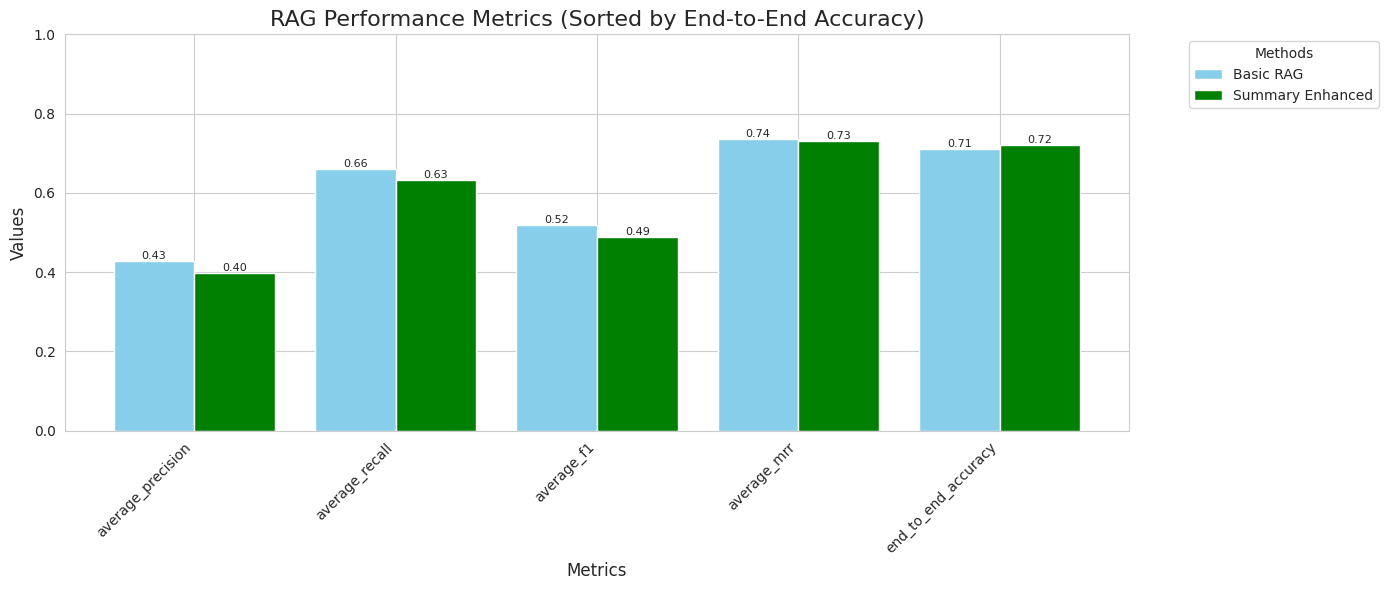

In [21]:
#let's visualize our accuracy
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Enhanced'], colors=['skyblue', 'green'])